In [1]:
import numpy as np
import random
import string
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

MIN_N_LEN = 3
MAX_N_LEN = 4
characters = string.digits + string.ascii_uppercase
width, height, n_class = 170, 80, len(characters)

captcha_generator = ImageCaptcha(width=width, height=height)

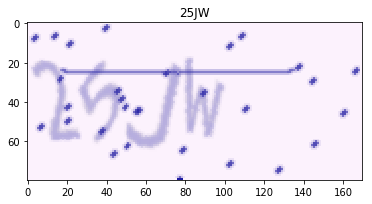

In [3]:
random_str = ''.join([random.choice(characters) for j in range(MAX_N_LEN)])
img = captcha_generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

# 固定长度验证码

In [4]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
#     y = np.zeros((batch_size, MAX_N_LEN, n_class))
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(MAX_N_LEN)]
    
    while True:
        for i in range(batch_size):
            code = ''.join([random.choice(characters) for j in range(MAX_N_LEN)])
            X[i,:] = captcha_generator.generate_image(code)
            for j, s in enumerate(code):
                y[j][i, :] = 0
                y[j][i, characters.find(s)] = 1
        
        yield X, y

In [3]:
from keras.layers import *
from keras.models import *

inputs = Input(shape=(height, width, 3))

x = inputs
for i in range(4):
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=32*(2**i), kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax')(x) for i in range(MAX_N_LEN)]

model = Model(inputs=inputs, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['categorical_accuracy'])
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 170, 3)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 80, 170, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 80, 170, 32)   9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 40, 85, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

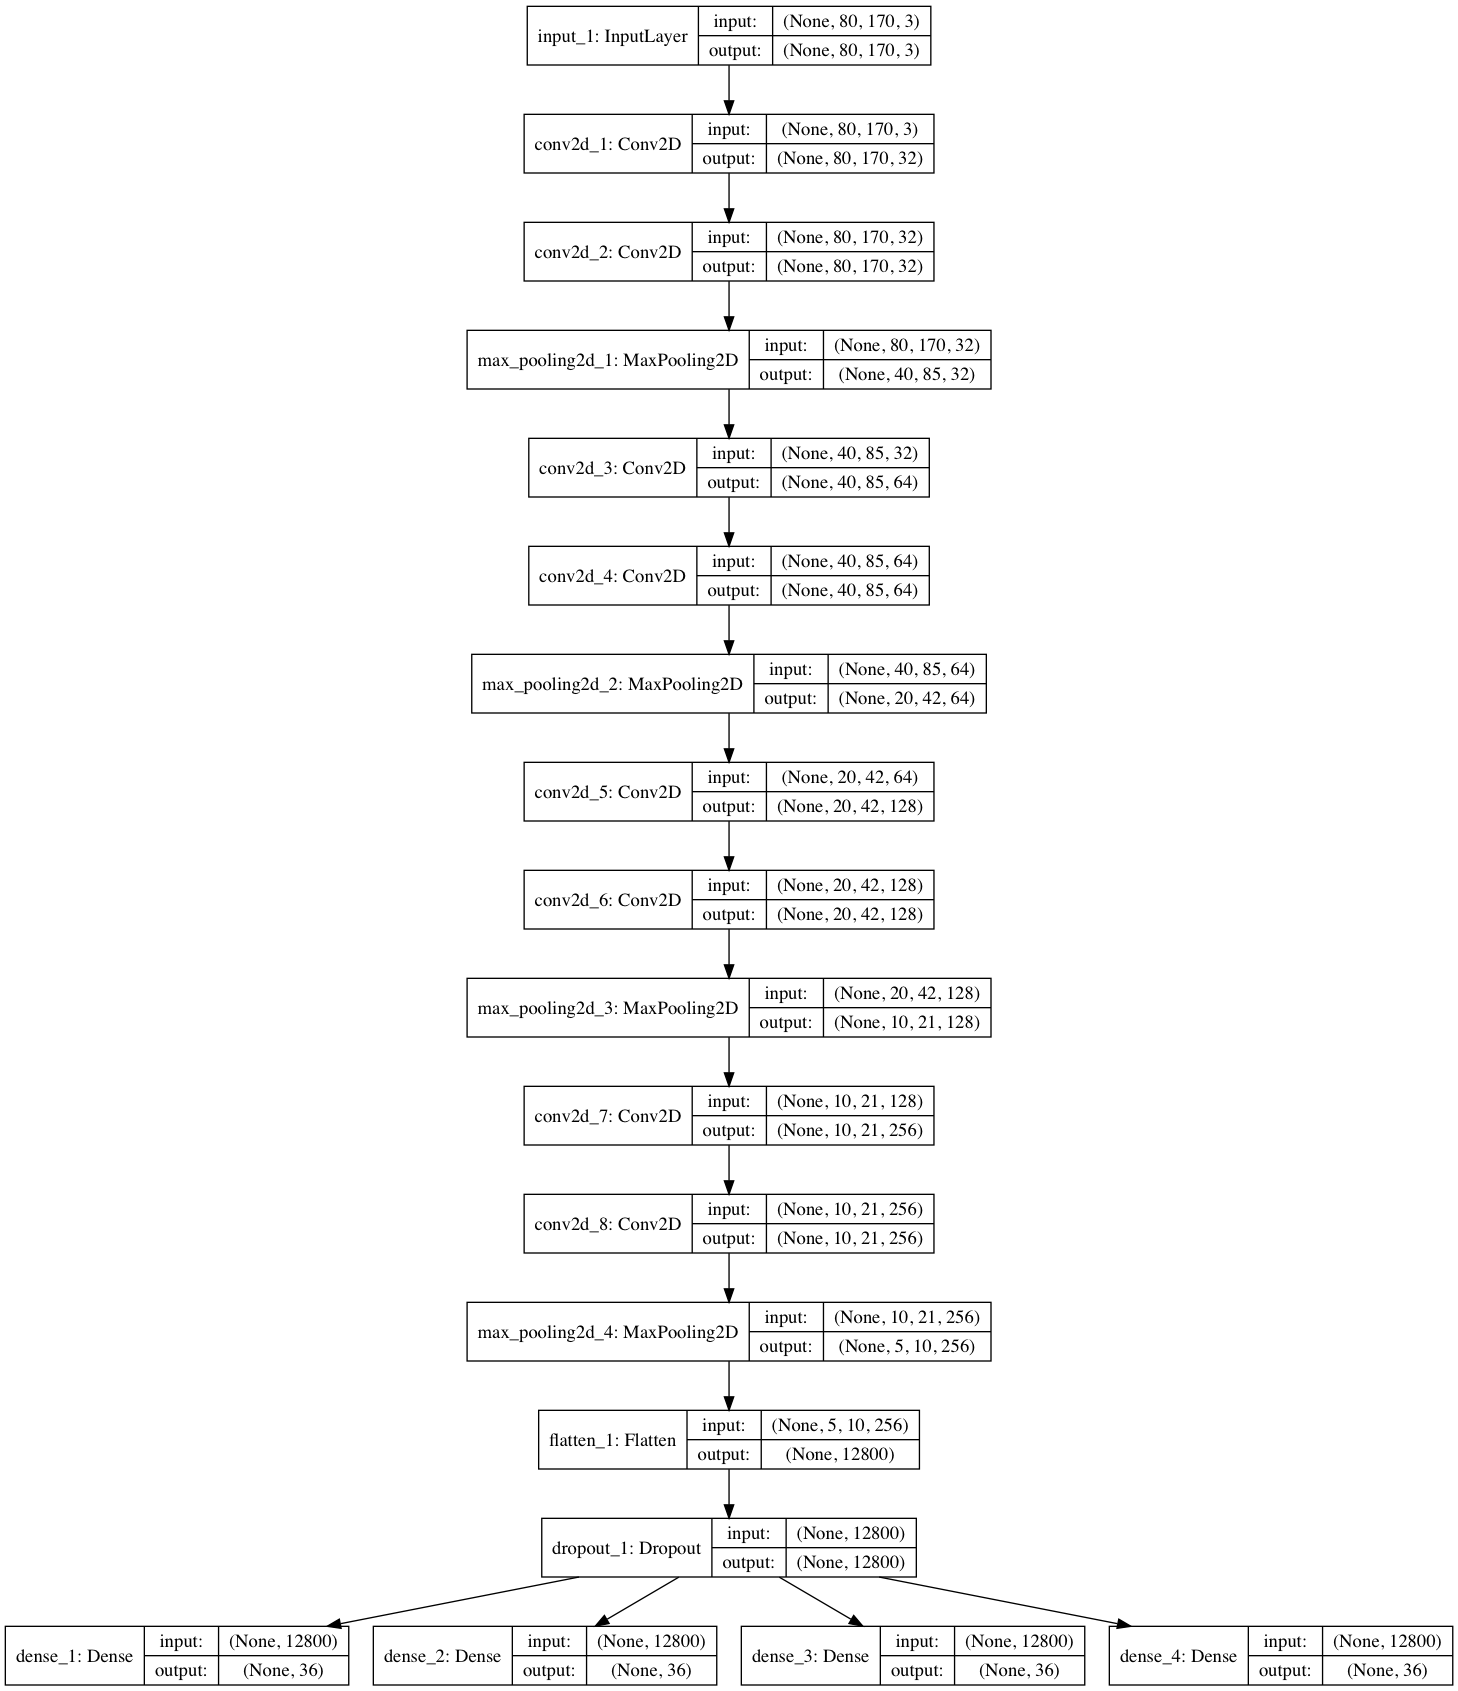

In [4]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="./assets/model.png", show_shapes=True)
Image('./assets/model.png')

In [15]:
from keras.callbacks import *

RUN = RUN + 1 if 'RUN' in locals() else 1
LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

EPOCHS = 128
STEPS_PER_EPOCH = 512

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit_generator(gen(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, 
                    validation_data=gen(), validation_steps=64,
                    callbacks=[tensorboard, checkpoint, early_stopping])

Epoch 1/128
512/512 [==============================] - 61s - loss: 14.5643 - dense_33_loss: 3.6438 - dense_34_loss: 3.6352 - dense_35_loss: 3.6438 - dense_36_loss: 3.6414 - dense_33_categorical_accuracy: 0.0294 - dense_34_categorical_accuracy: 0.0286 - dense_35_categorical_accuracy: 0.0285 - dense_36_categorical_accuracy: 0.0273 - val_loss: 14.3373 - val_dense_33_loss: 3.5840 - val_dense_34_loss: 3.5837 - val_dense_35_loss: 3.5842 - val_dense_36_loss: 3.5853 - val_dense_33_categorical_accuracy: 0.0283 - val_dense_34_categorical_accuracy: 0.0352 - val_dense_35_categorical_accuracy: 0.0259 - val_dense_36_categorical_accuracy: 0.0205
Epoch 2/128
512/512 [==============================] - 59s - loss: 14.3361 - dense_33_loss: 3.5836 - dense_34_loss: 3.5843 - dense_35_loss: 3.5841 - dense_36_loss: 3.5841 - dense_33_categorical_accuracy: 0.0301 - dense_34_categorical_accuracy: 0.0273 - dense_35_categorical_accuracy: 0.0278 - dense_36_categorical_accuracy: 0.0283 - val_loss: 14.3346 - val_dens

512/512 [==============================] - 60s - loss: 0.8946 - dense_33_loss: 0.1814 - dense_34_loss: 0.2156 - dense_35_loss: 0.2758 - dense_36_loss: 0.2218 - dense_33_categorical_accuracy: 0.9712 - dense_34_categorical_accuracy: 0.9597 - dense_35_categorical_accuracy: 0.9426 - dense_36_categorical_accuracy: 0.9600 - val_loss: 0.7035 - val_dense_33_loss: 0.1416 - val_dense_34_loss: 0.1840 - val_dense_35_loss: 0.2150 - val_dense_36_loss: 0.1629 - val_dense_33_categorical_accuracy: 0.9756 - val_dense_34_categorical_accuracy: 0.9624 - val_dense_35_categorical_accuracy: 0.9570 - val_dense_36_categorical_accuracy: 0.9692
Epoch 8/128
512/512 [==============================] - 60s - loss: 0.7367 - dense_33_loss: 0.1515 - dense_34_loss: 0.1725 - dense_35_loss: 0.2333 - dense_36_loss: 0.1794 - dense_33_categorical_accuracy: 0.9743 - dense_34_categorical_accuracy: 0.9669 - dense_35_categorical_accuracy: 0.9497 - dense_36_categorical_accuracy: 0.9636 - val_loss: 0.7955 - val_dense_33_loss: 0.167

In [16]:
model.load_weights('/output/training_logs/run4/checkpoint-08-0.5285.hdf5')

In [82]:
def decode(ys):
    if len(ys) == 0:
        return []
    
    ys_list = []
    batch_size = ys[0].shape[0]
    for i in range(batch_size):
        code = ''.join([characters[np.argmax(ys[j][i])] for j in range(MAX_N_LEN)])
        ys_list.append(code)
    return ys_list

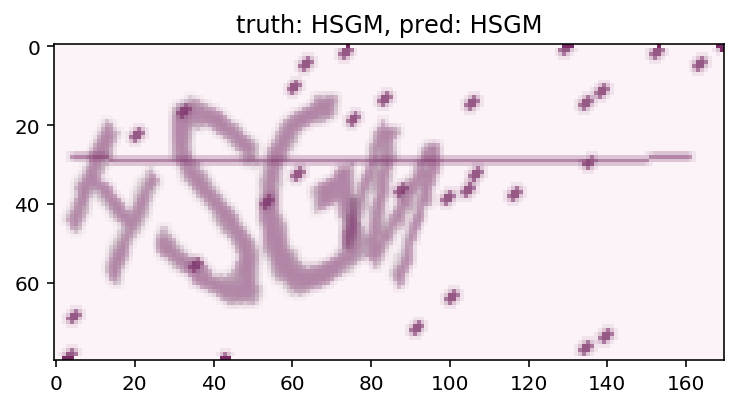

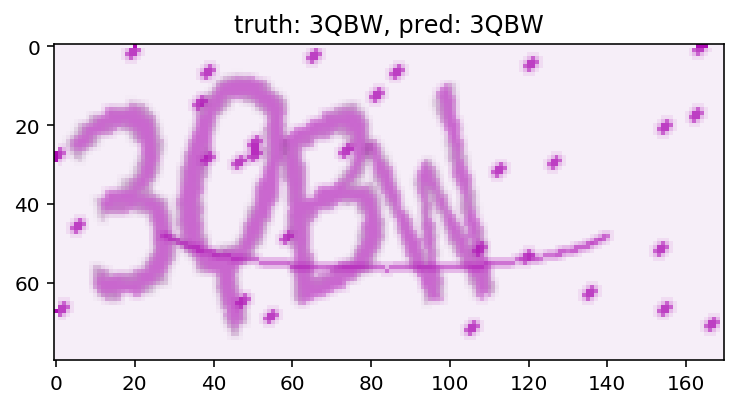

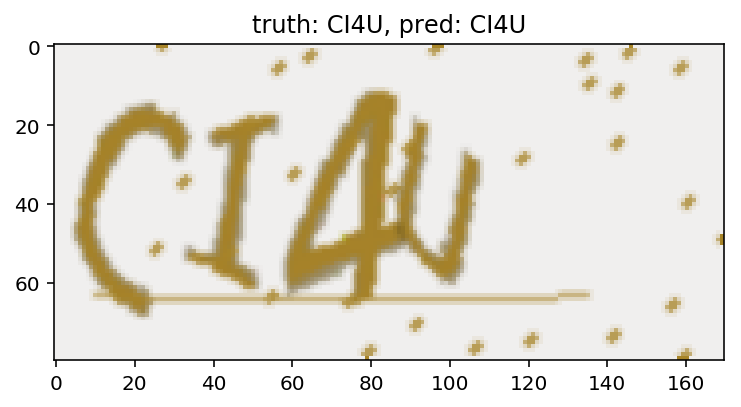

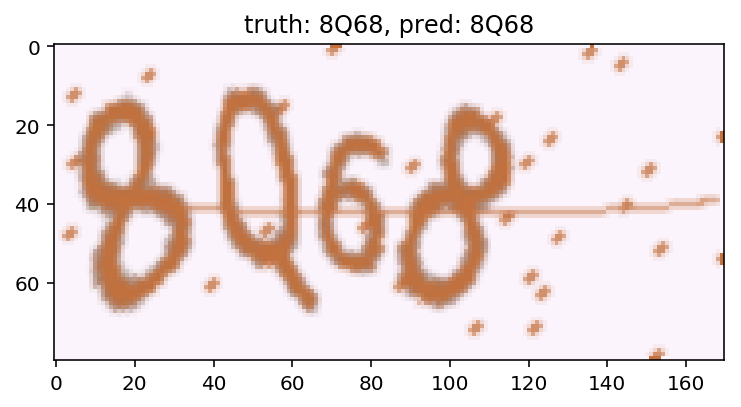

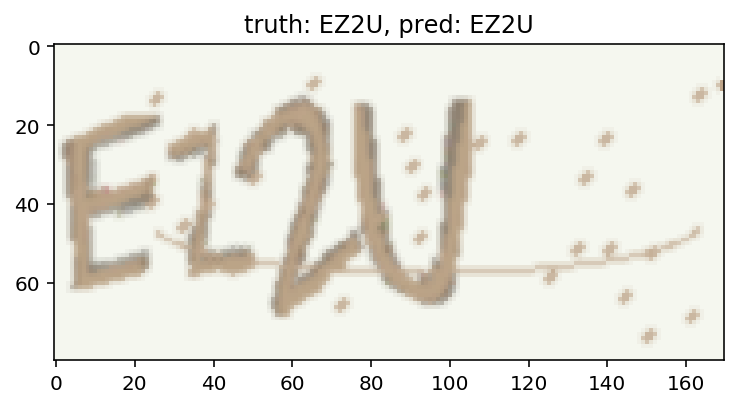

In [27]:
def test(i):
    X, y = next(gen(1))
    y_pred = model.predict(X)
    plt.figure(i)
    plt.title("truth: {}, pred: {}".format(decode(y)[0], decode(y_pred)[0]))
    plt.imshow(X[0])

for i in range(5):
    test(i)

# 非固定长度验证码

In [2]:
# Bug takes me a morning!!!
characters += ' '
n_class = len(characters)

In [3]:
from keras.models import *
from keras.layers import *
# from keras.layers import add
from keras import backend as K
from keras.callbacks import *

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [4]:
def get_ctc_model():
    # GRU(units), Positive integer, dimensionality of the output space
    # TODO change.
    rnn_size = 128

    input_tensor = Input((width, height, 3))
    x = input_tensor
    for i in range(3):
        x = Conv2D(32, kernel_size=3, activation='relu')(x)
        x = Conv2D(32, kernel_size=3, activation='relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # 后面generator需要用到
    conv_shape = x.get_shape()
    x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
    x = Dense(32, activation='relu')(x)

    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal')(x)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal')(x)
    # keras.layers.add
    gru1_merged = add([gru_1, gru_1b])

    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal')(gru1_merged)
    x = concatenate([gru_2, gru_2b])

    x = Dropout(0.25)(x)
    x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
    # 这里的base_model就是未来的预测model
    base_model = Model(inputs=input_tensor, outputs=x)

    labels = Input(name='the_labels', shape=[MAX_N_LEN], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])
    ctc_model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])

    # 'ctc': lambda y_true, y_pred: y_pred, brief function
    # ctc-loss is the target, as well as the training objective
    ctc_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')
    # ctc_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer='adadelta')
    
    return base_model, ctc_model

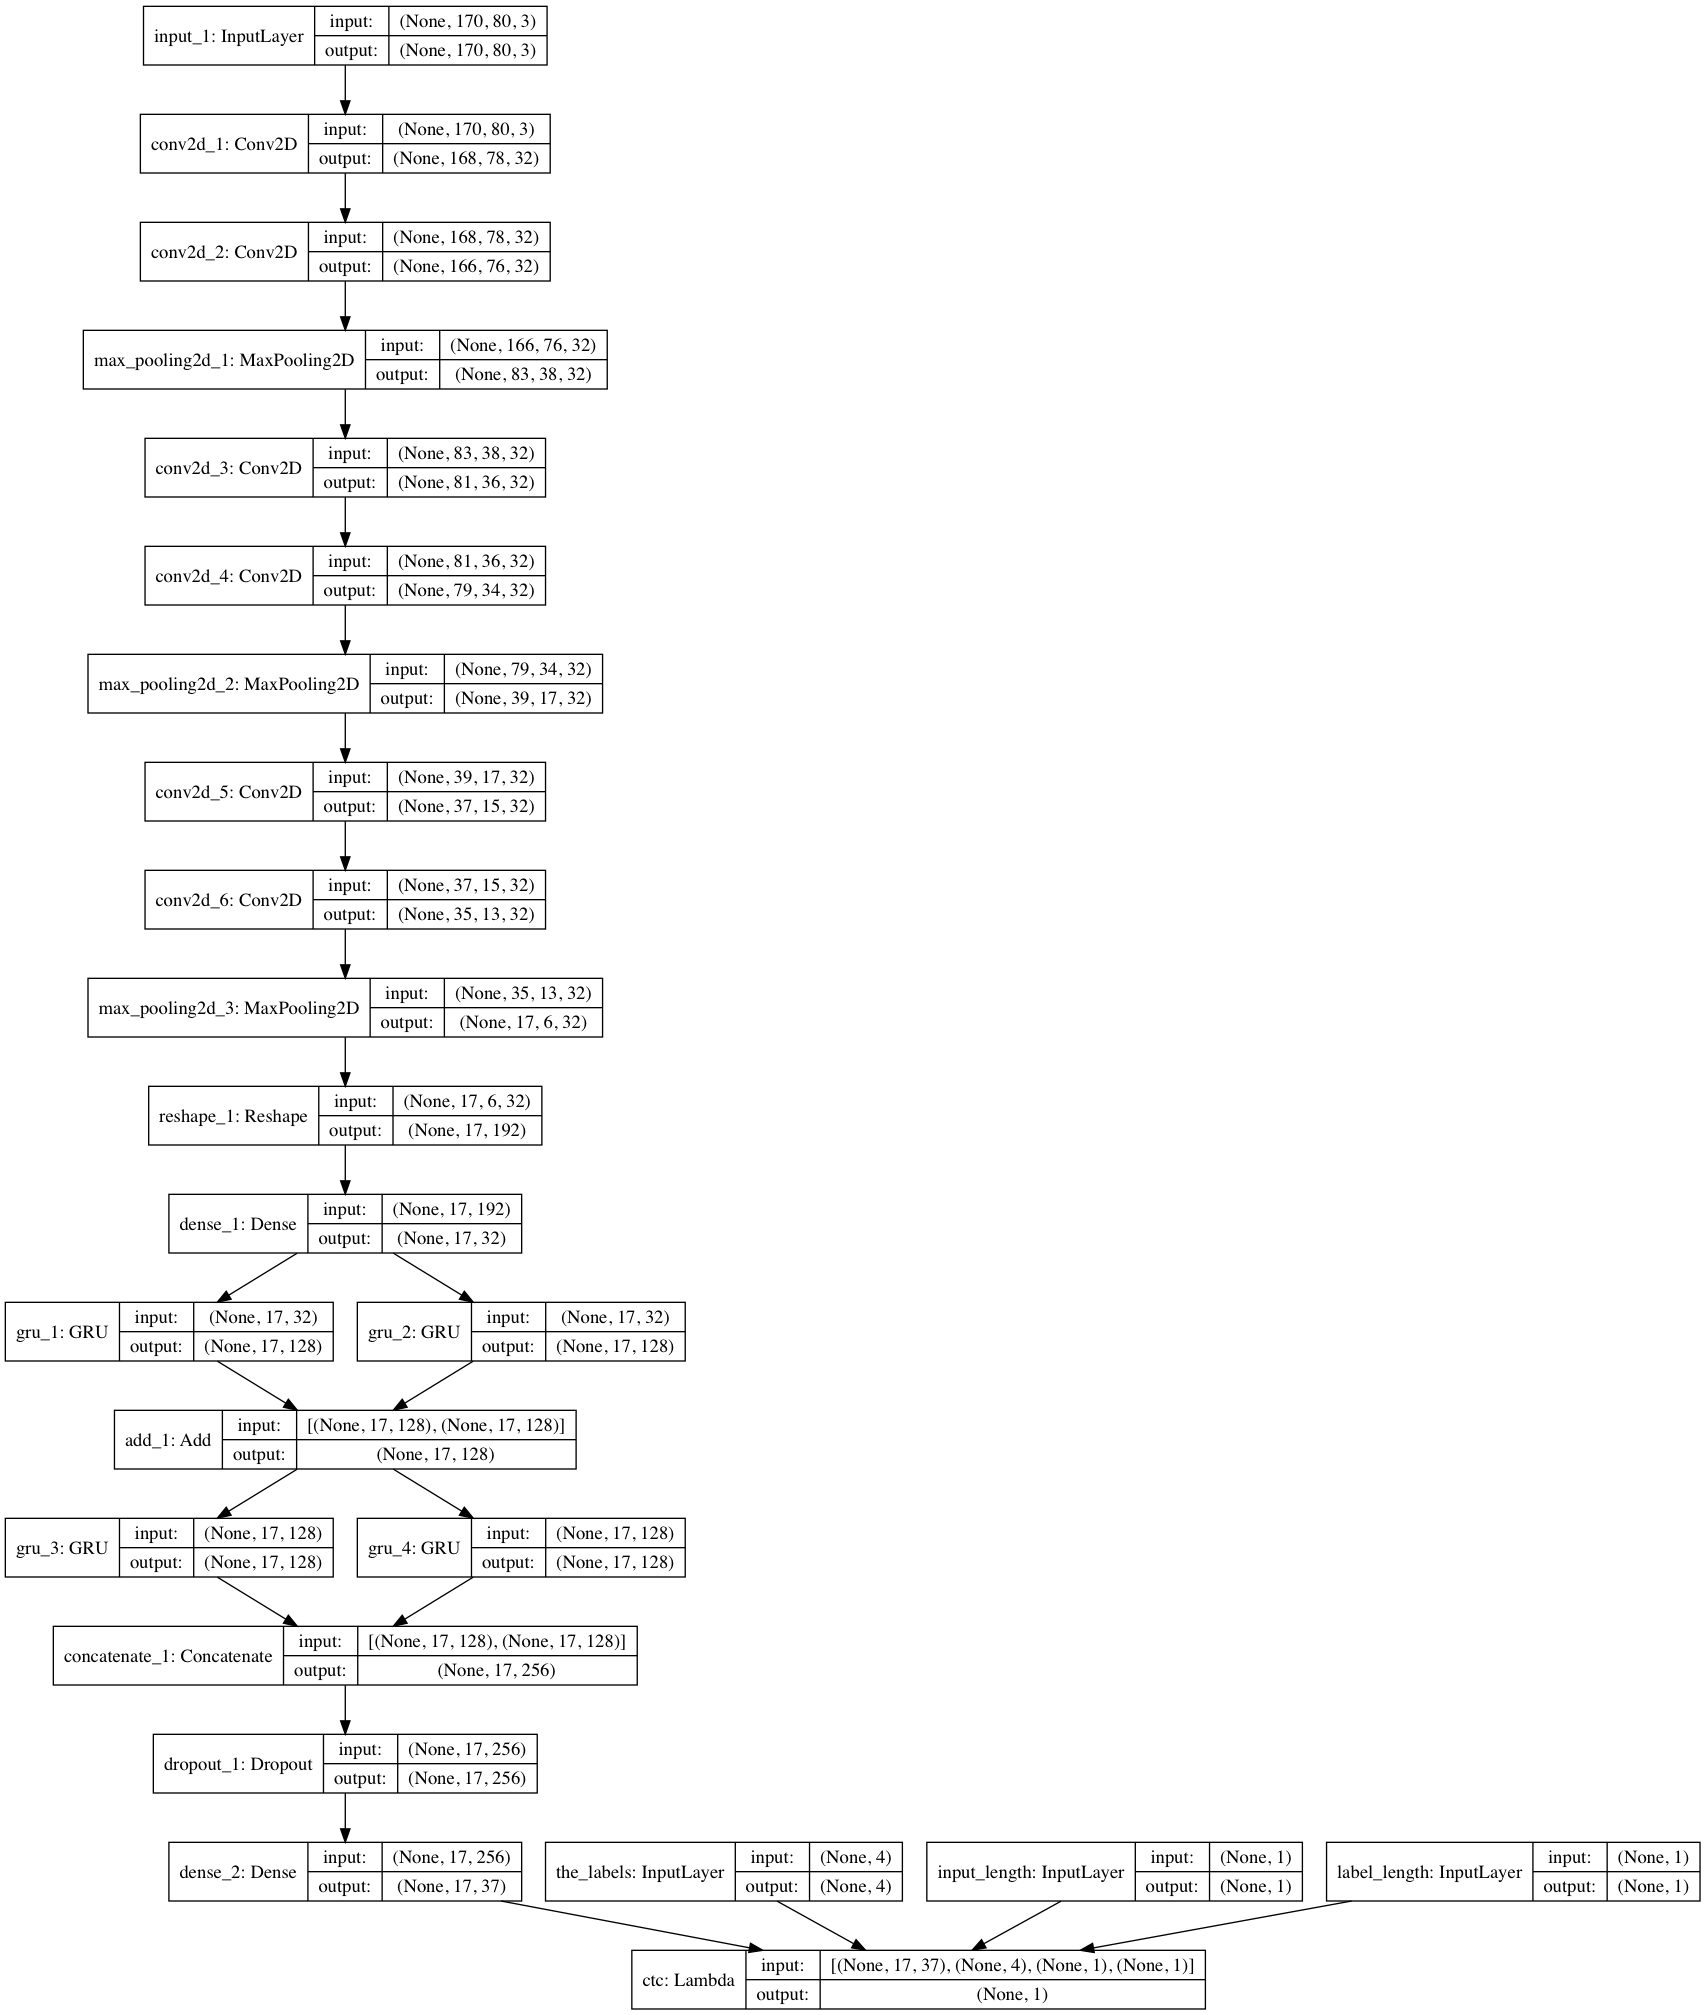

In [5]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(ctc_model, to_file="/tmp/ctc_model.png", show_shapes=True)
Image('/tmp/ctc_model.png')

In [5]:
def ctc_gen(batch_size=32, is_dynamic_len = False):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    input_length = np.ones(batch_size) * 15 # int(conv_shape[1] - 2), model decided, static
    label_length = np.zeros(batch_size) # might be dynamic

    while True:
        # 每次循环y都需要reset，默认设置成为第n_class-1的那个，可以认为是空
        y = np.ones((batch_size, MAX_N_LEN), dtype=np.uint8) * (n_class-1)
        
        for i in range(batch_size):
            the_len = random.randint(MIN_N_LEN, MAX_N_LEN) if is_dynamic_len else MAX_N_LEN
            code = ''.join([random.choice(characters) for j in range(the_len)])
            # height,width,channel -> width,height,channel
            X[i] = np.array(captcha_generator.generate_image(code)).transpose(1, 0, 2)
            y[i, :the_len] = [characters.find(c) for c in code] # [1, 25, 0, 4, -1]
            label_length[i] = the_len
        
        # input_length就是计算CTC的输入长度，也就是图片的宽度，可以从模型中，CTC计算前的第二个维度
        # （第一个是batch_size）中看出来。对于一个模型而言，这个是固定值。
        # 减去2是因为 the 2 is critical here since the first couple outputs of the RNN tend to be garbage
        yield [X, y, input_length, label_length], np.zeros(batch_size) # batch_ones

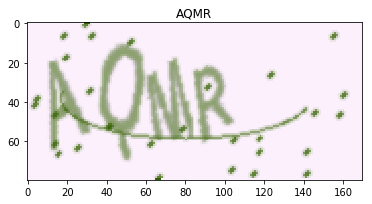

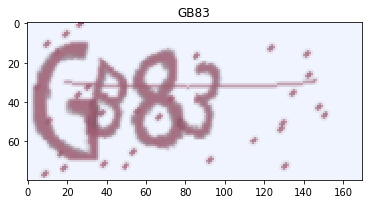

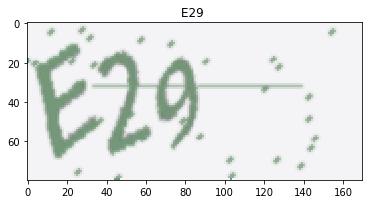

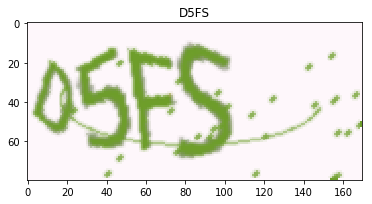

In [9]:
[X_sample, y_sample, _, _], _ = next(ctc_gen(4, is_dynamic_len=True))
for i in range(4):
    plt.figure(i)
    text = ''.join([characters[j] for j in y_sample[i]])
    plt.title(text)
    plt.imshow(X_sample[i].transpose(1, 0, 2))

In [6]:
class ModelEvaluator(Callback):
    def __init__(self, is_dynamic_len):
        self.eva_batch_size = 100
        self.eva_gen = ctc_gen(self.eva_batch_size, is_dynamic_len=is_dynamic_len)
        
    def on_epoch_end(self, epoch, logs=None):
        [X_test, y_test, _, _], _ = next(self.eva_gen)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        y_pred = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])

        if y_pred.shape == y_test.shape:
            m = (y_test == y_pred)
            digit_acc = m.sum().sum() / (self.eva_batch_size * y_test.shape[1])
            line_acc = np.sum([l.all() for l in m]) / self.eva_batch_size
            print('Digit acc {}, Line acc {}'.format(digit_acc, line_acc))
        else:
            print('y_test {} and y_pred {} have different size'.format(y_test.shape, y_pred.shape))

In [7]:
RUN = RUN + 1 if 'RUN' in locals() else 1
LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

In [69]:
# Static Run
# 这段是在MAX_N_LEN=3的情况下（考虑到训练速度，不过没想到还是很慢，醉了），设置is_dynamic_len=False跑出的结果。
is_dynamic_len = False
evaluator = ModelEvaluator(is_dynamic_len=False)
base_model, ctc_model = get_ctc_model()
ctc_model.fit_generator(ctc_gen(128, is_dynamic_len=False), steps_per_epoch=64, epochs=10240, verbose=1, 
                    validation_data=ctc_gen(32, is_dynamic_len=False), validation_steps=4,
                    callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

Epoch 1/10240
63/64 [============================>.] - ETA: 0s - loss: 13.3529Epoch 00000: val_loss improved from inf to 12.19869, saving model to /output/training_logs/run11/checkpoint-00-12.1987.hdf5
y_test (100, 3) and y_pred (100, 0) have different size
64/64 [==============================] - 34s - loss: 13.3351 - val_loss: 12.1987
Epoch 2/10240
63/64 [============================>.] - ETA: 0s - loss: 12.1922Epoch 00001: val_loss did not improve
y_test (100, 3) and y_pred (100, 0) have different size
64/64 [==============================] - 24s - loss: 12.1939 - val_loss: 12.3184
Epoch 3/10240
63/64 [============================>.] - ETA: 0s - loss: 12.3370Epoch 00002: val_loss did not improve
y_test (100, 3) and y_pred (100, 0) have different size
64/64 [==============================] - 24s - loss: 12.3441 - val_loss: 13.1425
Epoch 4/10240
63/64 [============================>.] - ETA: 0s - loss: 12.2065Epoch 00003: val_loss improved from 12.19869 to 12.08517, saving model to /ou

63/64 [============================>.] - ETA: 0s - loss: 11.1370Epoch 00028: val_loss improved from 10.60442 to 10.09866, saving model to /output/training_logs/run11/checkpoint-28-10.0987.hdf5
Digit acc 0.056666666666666664, Line acc 0.0
64/64 [==============================] - 24s - loss: 11.1256 - val_loss: 10.0987
Epoch 30/10240
63/64 [============================>.] - ETA: 0s - loss: 10.8382Epoch 00029: val_loss did not improve
Digit acc 0.08666666666666667, Line acc 0.0
64/64 [==============================] - 24s - loss: 10.8332 - val_loss: 10.4881
Epoch 31/10240
63/64 [============================>.] - ETA: 0s - loss: 10.7838Epoch 00030: val_loss did not improve
y_test (100, 3) and y_pred (100, 2) have different size
64/64 [==============================] - 24s - loss: 10.7896 - val_loss: 11.5790
Epoch 32/10240
63/64 [============================>.] - ETA: 0s - loss: 10.7360Epoch 00031: val_loss improved from 10.09866 to 9.85457, saving model to /output/training_logs/run11/check

Digit acc 0.51, Line acc 0.2
64/64 [==============================] - 24s - loss: 7.2926 - val_loss: 4.2601
Epoch 57/10240
63/64 [============================>.] - ETA: 0s - loss: 7.1316Epoch 00056: val_loss did not improve
Digit acc 0.4766666666666667, Line acc 0.16
64/64 [==============================] - 24s - loss: 7.0877 - val_loss: 4.4603
Epoch 58/10240
63/64 [============================>.] - ETA: 0s - loss: 7.1643Epoch 00057: val_loss improved from 4.19926 to 3.91132, saving model to /output/training_logs/run11/checkpoint-57-3.9113.hdf5
Digit acc 0.49, Line acc 0.18
64/64 [==============================] - 24s - loss: 7.1161 - val_loss: 3.9113
Epoch 59/10240
63/64 [============================>.] - ETA: 0s - loss: 6.8854Epoch 00058: val_loss did not improve
Digit acc 0.6166666666666667, Line acc 0.29
64/64 [==============================] - 24s - loss: 6.8413 - val_loss: 4.0341
Epoch 60/10240
63/64 [============================>.] - ETA: 0s - loss: 6.9212Epoch 00059: val_loss d

Digit acc 0.8233333333333334, Line acc 0.63
64/64 [==============================] - 24s - loss: 5.8166 - val_loss: 1.5084
Epoch 88/10240
63/64 [============================>.] - ETA: 0s - loss: 5.7522Epoch 00087: val_loss did not improve
Digit acc 0.8433333333333334, Line acc 0.66
64/64 [==============================] - 24s - loss: 5.6920 - val_loss: 1.5553
Epoch 89/10240
63/64 [============================>.] - ETA: 0s - loss: 5.7190Epoch 00088: val_loss improved from 1.50840 to 1.45418, saving model to /output/training_logs/run11/checkpoint-88-1.4542.hdf5
Digit acc 0.8966666666666666, Line acc 0.75
64/64 [==============================] - 24s - loss: 5.6598 - val_loss: 1.4542
Epoch 90/10240
63/64 [============================>.] - ETA: 0s - loss: 5.7275Epoch 00089: val_loss did not improve
Digit acc 0.8233333333333334, Line acc 0.63
64/64 [==============================] - 24s - loss: 5.6719 - val_loss: 1.6852
Epoch 91/10240
63/64 [============================>.] - ETA: 0s - loss: 

In [14]:
# Dynamic Run
# 这段是在设置MIN_N_LEN = 3， MAX_N_LEN= 4，is_dynamic_len=True跑出的结果
evaluator = ModelEvaluator(is_dynamic_len=True)
base_model, ctc_model = get_ctc_model()
ctc_model.fit_generator(ctc_gen(128, is_dynamic_len=True), steps_per_epoch=64, epochs=10240, verbose=1, 
                    validation_data=ctc_gen(32, is_dynamic_len=True), validation_steps=4,
                    callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

Epoch 1/10240
63/64 [============================>.] - ETA: 0s - loss: 5.5156Epoch 00000: val_loss improved from 5.50407 to 4.86473, saving model to /output/training_logs/run1/checkpoint-00-4.8647.hdf5
Digit acc 0.39, Line acc 0.05
64/64 [==============================] - 27s - loss: 5.5126 - val_loss: 4.8647
Epoch 2/10240
63/64 [============================>.] - ETA: 0s - loss: 5.8831Epoch 00001: val_loss improved from 4.86473 to 4.23818, saving model to /output/training_logs/run1/checkpoint-01-4.2382.hdf5
y_test (100, 4) and y_pred (100, 5) have different size
64/64 [==============================] - 26s - loss: 5.8551 - val_loss: 4.2382
Epoch 3/10240
63/64 [============================>.] - ETA: 0s - loss: 5.0552Epoch 00002: val_loss improved from 4.23818 to 3.37488, saving model to /output/training_logs/run1/checkpoint-02-3.3749.hdf5
y_test (100, 4) and y_pred (100, 5) have different size
64/64 [==============================] - 26s - loss: 5.0362 - val_loss: 3.3749
Epoch 4/10240
6

In [ ]:
def model_evaluate(model):
    _test_len = 10
    [X_test, y_test, _, _], _ = next(ctc_gen(_test_len, is_dynamic_len=True))
    y_pred = model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    y_pred = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])

    for i in range(_test_len):
        plt.figure(i)
        y_test_text = ''.join([characters[i] for i in y_test[i]])
        y_perd_text = ''.join([characters[i] for i in y_pred[i]])
        plt.title("truth: {}, pred: {}".format(y_test_text, y_perd_text))
        plt.imshow(X_test[i].transpose(1, 0, 2))

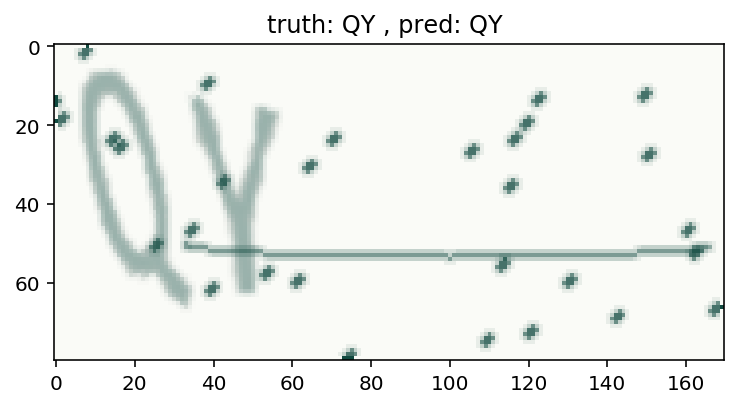

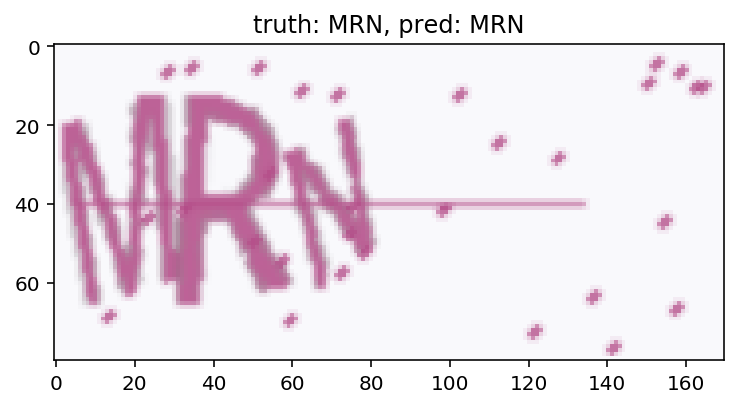

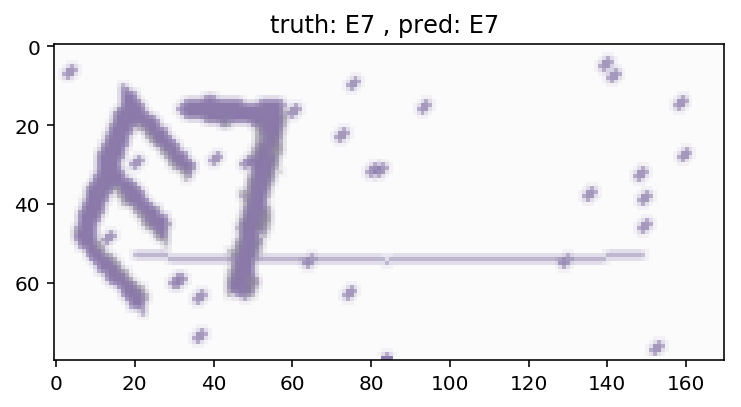

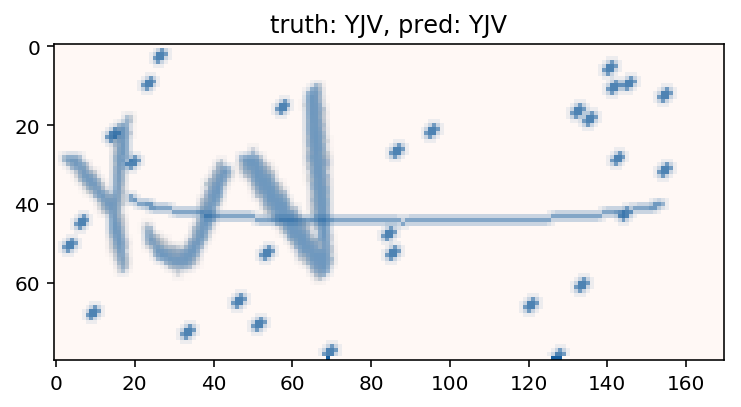

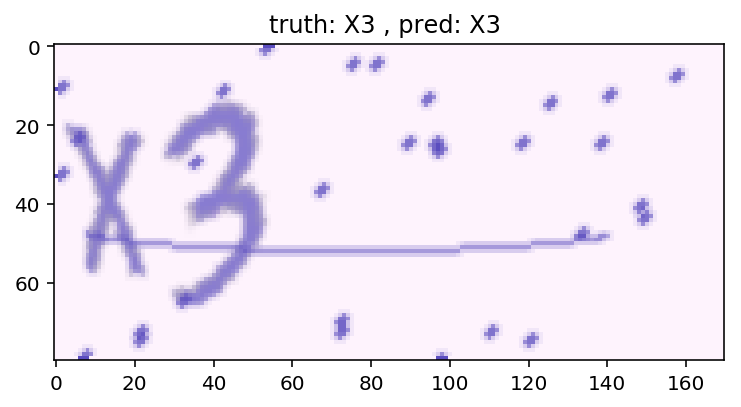

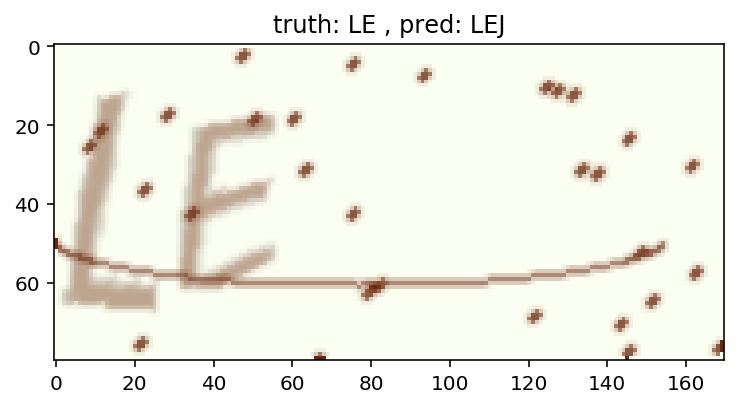

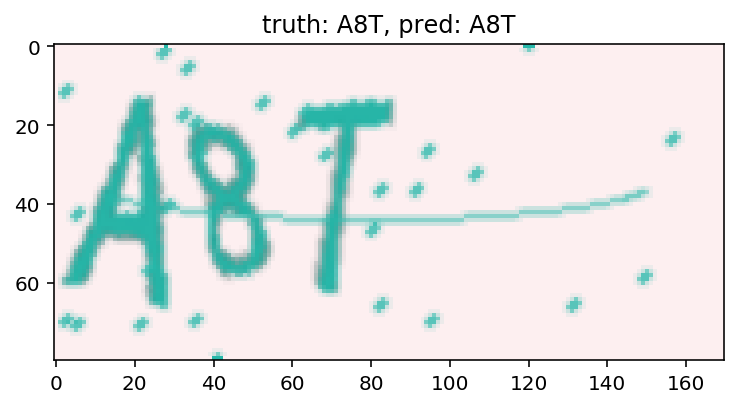

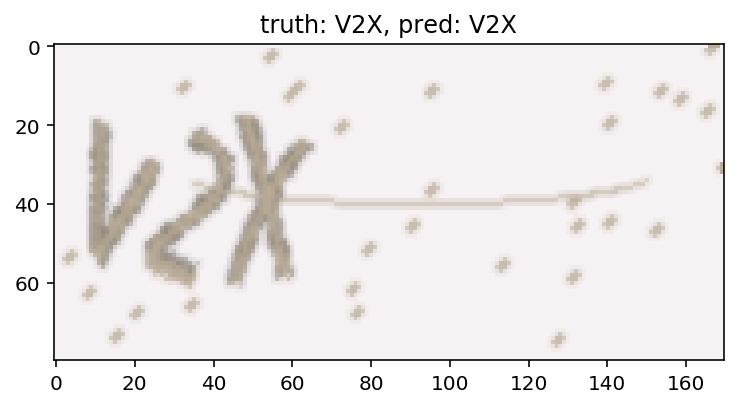

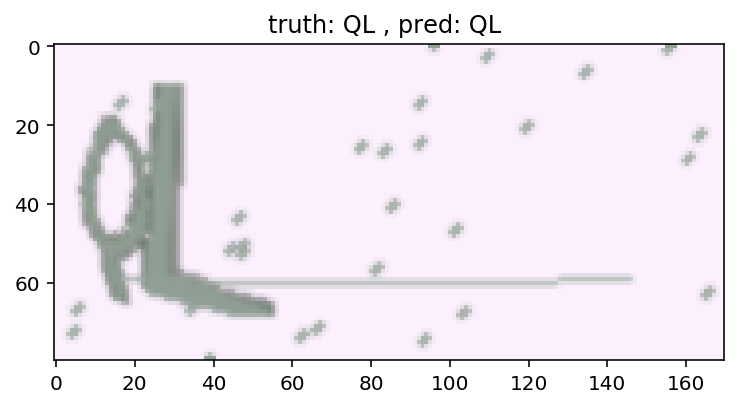

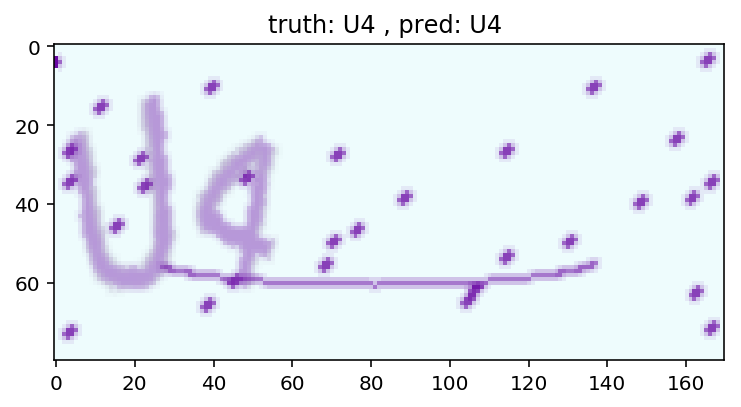

In [130]:
# base_model.load_weights('/input/Captcha/checkpoint-33-0.3923.hdf5')
# base_model.load_weights('/input/Captcha/checkpoint-112-0.8002.hdf5')
# base_model.load_weights('/input/Captcha/checkpoint-29-0.8634.hdf5')
base_model.load_weights('/input/Captcha/checkpoint-33-0.3923.hdf5')
model_evaluate(base_model)